In [1]:
import os
import contextlib
import io
import getpass
from dotenv import load_dotenv
from enum import Enum
import os
from rich.markdown import Markdown
from rich import print as md
from langchain.output_parsers import PydanticOutputParser
load_dotenv()
from langchain_openai.chat_models import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from typing import Annotated, List, Sequence, Tuple, TypedDict, Union
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage
import operator
from langchain_core.agents import AgentFinish
from langgraph.prebuilt.tool_executor import ToolExecutor
from langgraph.graph import END, StateGraph
import json

from langchain_core.messages import (
    AIMessage,
    BaseMessage,
    ChatMessage,
    FunctionMessage,
    HumanMessage,
)
from langchain.tools.render import format_tool_to_openai_function
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph
from langgraph.prebuilt.tool_executor import ToolExecutor, ToolInvocation
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from pydantic import BaseModel, Field, validator
from Models.models import LLMModel



#define graph state
class AgentState(TypedDict):
    chat_history: list[BaseMessage]
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str
    user_config:dict
    
    
#Nodes Output schema
class StandardResponse(BaseModel):
    """Represents a standard response from the agent/ai."""
    response: str = Field(description="your actual response/answer in markdown format")
    sender: str = Field(description="your name in lowercase")
    directed_to: str = Field(description="your response must be directed to another agent or to human")
    
#Base Prompt Template   
def get_base_prompt_template(name=None, custom_instructions=None, agents=None):
    prompt_template = ChatPromptTemplate.from_messages(
    [
    (
    "system",
    "Your name is {name} and you are working along side other agents as listed below "
    "Agents: \n {agents} "
    "{custom_instructions} "
    ""
    )
    ]
    )
    
    prompt_template = prompt_template.partial(name=name)
    prompt_template = prompt_template.partial(agents=agents)
    prompt_template = prompt_template.partial(custom_instructions=custom_instructions if custom_instructions else "")
    return prompt_template

#Notebook loader
import nbformat
def load_notebook(path):
    with open(path) as f:
        nb = nbformat.read(f, as_version=4)
    return nb


#### TOOLS




In [2]:
@tool
def python_repl(code: Annotated[str, "The python code to execute."]):
    """Use this to execute python code when needed. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user and you.
    """
    # Create StringIO objects to capture stdout and stderr
    stdout = io.StringIO()
    stderr = io.StringIO()

    # Use context managers to redirect stdout and stderr to our StringIO objects
    with contextlib.redirect_stdout(stdout), contextlib.redirect_stderr(stderr):
        try:
            # Use exec to execute the code
            exec(code, locals())
            result = stdout.getvalue()
            error = stderr.getvalue()
        except Exception as e:
            # If an error occurs during execution, return the error message
            return f"Failed to execute. Error: {repr(e)}"

    # If no errors occurred, return the output
    if error:
        return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}\nStderr: {error}"
    else:
        return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"



@tool
def write_file(name: Annotated[str, "The name of the file."], content: Annotated[str, "The content of the file."]):
    """This tool writes a file with the given name and content to the Playground directory."""
    # Define the directory
    directory = "Playground"
    
    # Create the directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # Define the file path
    file_path = os.path.join(directory, name)
    
    # Write the content to the file
    try:
        with open(file_path, 'w') as file:
            file.write(content)
        status = "File created successfully"
    except Exception as e:
        status = f"Failed to create file. Error: {repr(e)}"
    
    # Return the name and status of creation
    return {"full_path": file_path, "status": status}

@tool
def run_js_code(js_code: Annotated[str, "The JavaScript code to run."]):
    """This tool runs the provided JavaScript code and returns the result."""
    # Use execjs to execute the JavaScript code
    ctx = execjs.compile(js_code)

    # Get the result of the JavaScript code
    result = ctx.eval('result')

    # Return the result
    return {"result": result}


all_tools = [
            python_repl,
            write_file,
            run_js_code
        ]

#### CODE EXTRACTOR

In [3]:

code_extractor_prompt_template = get_base_prompt_template(
    name="code_extractor",
    custom_instructions="Your role is to extract the code provided by the AI assistant from the conversation in the notebook. "
                        "Once you've extracted the code, forward it to the agent named testers without making any changes. ",
    agents="testers"
)

code_extractor = LLMModel(
    provider="openai_api",
    model="gpt-4o",
    use_history=False,
    #use_tool=False,
    output_schema=StandardResponse.model_json_schema(),
    prompt_template=code_extractor_prompt_template
)



#### HAPPY_PATH AND EDGE_CASE

In [4]:

# Happy Pather Agent
happy_pather_prompt_template = get_base_prompt_template(
    name="happy_pather aka testers",
    custom_instructions="Your role is to generate and list  happy path  test cases that should be tested (not test code). "
                        "Once you've created the test cases, share them with another agent called codia. ",
    agents="codia"
)

happy_pather = LLMModel(
    provider="openai_api",
    model="gpt-4o",
    use_history=False,
    #use_tool=False,
    output_schema=StandardResponse.model_json_schema(),
    prompt_template=happy_pather_prompt_template
)

# Edge Caser Agent
edge_caser_prompt_template = get_base_prompt_template(
    name="edge_caser aka testers",
    custom_instructions="Your role is to generate and list edge case test cases that should be tested (not test code) for the provided code. "
                        "Once you've created the test cases, share them with another agent called codia. ",
                      
    agents="codia"
)

edge_caser = LLMModel(
    provider="openai_api",
    model="gpt-4o",
    use_history=False,
    #use_tool=False,
    output_schema=StandardResponse.model_json_schema(),
    prompt_template=edge_caser_prompt_template
)



### ISSUE FINDER, ISSUE VERIFFER and TESTER NODE

In [5]:

# Issue Finder Agent
issue_finder_prompt_template = get_base_prompt_template(
    name="issue_finder",
    custom_instructions="Your role is to identify and list issues with the provided code. "
                        "Once you've identified the issues, share them with another agent called issue_verify. ",
    agents="issue_verify"
)

issue_finder = LLMModel(
    provider="openai_api",
    model="gpt-4o",
    use_history=False,
    #use_tool=False,
    output_schema=StandardResponse.model_json_schema(),
    prompt_template=issue_finder_prompt_template
)



#### CODIA

In [6]:
codia_prompt_template = get_base_prompt_template(
    name="codia",
    custom_instructions="Think step by step:"
                        "1. You will receive a list of happy path test cases and edge cases."
                        "2. Your job is to generate a function to test each of the provided cases."
                        "3. Share the generated function with code_checker."
                        "4. The aim is not to improve the original code but to test it."
                        "5. code_checker can either ask you to make an adjustment to the code to make it safe or more efficient if not the user will execute the code using a function called_ and show you the results."
                        "6. When code_checker asks for adjustments, make the necessary adjustments and show her, do this until she informs you she/he is satisfied with the code and has executed it. At this point, you will be shown the results of the execution."
                        "7. Ensure you use the print function within your code to get more feedback."
                        "8. Take note that the functions have to be defined (stand alone executed code) within the code to be executed successfully."
                        "9. Finally, you can gather all observations and generate your final evaluation results."
                        "10. I REPEAT, always forward a complete code to code_checker that can be executed as a stand alone code."
                        "ONCE YOU HAVE YOUR FINAL EVALUATION, PROVIDE IT IN DETAILS AND ENSURE YOU DIRECT IT TO the 'eval_merger' agent",
    agents="code_checker and eval_merger"
)

codia = LLMModel(
    provider="openai_api",
    model="gpt-4o",
    use_tool=True,
    use_history=False,
    output_schema=StandardResponse,
    prompt_template=codia_prompt_template
)



#### CODIA CODE REFLECTOR AND RUNNER

In [7]:
code_checker_prompt_template = get_base_prompt_template(
    name="code_checker",
    custom_instructions="You a professional python developer with years of experience in programming called code_checker."
                        "You are working along side other agents [codia and code_runner]"
                        "The codia will provide code which is meant to be tests for a function, your job is simple: "
                        "First you must say if the code is safe to run on a machine, and also suggest why and the corrections to make it safe"
                        "Lastly also suggest betters ways to write the code if needed for better performance."
                        "if You are ok with the code after some few iterations, go ahead and forward the entire code to code_runner who will then run the code and provide you with results"
                        "Finally, you can forward that result from code_runner back to codia",
    agents="codia and code_runner"
)

code_checker = LLMModel(
    provider="openai_api",
    model="gpt-4o",
    use_tool=True,
    use_history=False,
    output_schema=StandardResponse,
    prompt_template=code_checker_prompt_template
)




code_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            
            
            "You are a professional python developer with years of experience in programming, known as code_runner."
            "Your primary responsibilities include the following steps:"
            "1. Run code using the provided tools (python_repl and write_file)."
            "2. The write_file tool can be used to create dummy files such as csv, json etc. for testing purposes."
            "3. The code you receive is typically test code."
            "4. After running the code, report your observations in detail."
            "NOTE: avoid using: if __name__ == '__main__' as this wont allow the code to run"
            "5. Your observations should be directed back to the sender: code_checker."
            "6. Ensure that all your final responses (observations) are in JSON format using this schema{schema}."
            
            

            
        ),
        MessagesPlaceholder(variable_name="messages")
    ])

parser = PydanticOutputParser(pydantic_object=StandardResponse)
standard_format = parser.get_format_instructions()
code_prompt = code_prompt.partial(schema = standard_format )
llm3 = ChatOpenAI(model="gpt-4o", model_kwargs = {"response_format":{"type": "json_object"}}
                 )
functions = [format_tool_to_openai_function(t) for t in all_tools]
model3 = code_prompt | llm3.bind_functions(functions)

def code_runner(state):
    out = model3.invoke(state)
    if "function_call" in out.additional_kwargs:
        message = [HumanMessage(content=out.content, additional_kwargs=out.additional_kwargs)]
    else:
        message = [HumanMessage(content=out.content)]
    print("TYPE:", out)
    
    return {
        "messages":message,
        "sender": "code_runner",
    }



#Tool Executor
tool_executor = ToolExecutor(all_tools)
def tool_node(state):

    """This runs tools in the graph

    It takes in an agent action and calls that tool and returns the result."""
    messages = state["messages"]
  
    # Based on the continue condition
    # we know the last message involves a function call
    last_message = messages[-1]
    # We construct an ToolInvocation from the function_call
    try:
        tool_input = json.loads(
            last_message.additional_kwargs["function_call"]["arguments"]
        )
    except:
        tool_input = {"code":last_message.additional_kwargs["function_call"]["arguments"]} #sometimes the actual code is sent as a string instead of {code:"code"}
    # We can pass single-arg inputs by value
    if len(tool_input) == 1 and "__arg1" in tool_input:
        tool_input = next(iter(tool_input.values()))
    tool_name = last_message.additional_kwargs["function_call"]["name"]
    action = ToolInvocation(
        tool=tool_name,
        tool_input=tool_input,
    )
    # We call the tool_executor and get back a response
    response = tool_executor.invoke(action)
    # We use the response to create a FunctionMessage
    function_message = FunctionMessage(
        content=f"{tool_name} response: {str(response)}", name=action.tool
    )
    # We return a list, because this will get added to the existing list
    return {"messages": [function_message]}
        


/Users/daniel/anaconda3/envs/evaluator/lib/python3.12/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The function `format_tool_to_openai_function` was deprecated in LangChain 0.1.16 and will be removed in 0.3.0. Use langchain_core.utils.function_calling.convert_to_openai_function() instead.
  warn_deprecated(


#### MERGER

In [8]:
class Code(BaseModel):
    code: str = Field(description=" complete code to be executed")


class Severity(Enum):
    CRITICAL = "Critical"
    MEDIUM = "Medium"
    LOW = "Low"

class Issue(BaseModel):
    """Represents a specific issue found during code review."""

    cell_position: int = Field(
        ..., description="The position of the cell where the issue was found."
    )
    what: str = Field(..., description="A brief description of the issue.")
    why: str = Field(..., description="Explanation of why this is an issue.")
    where: str = Field(
        ...,
        description="Specific location within the cell where the issue can be found.",
    )
    severity: Severity = Field(
        ...,
        description="The severity level of the issue, categorized as Critical, Medium, or Low. Critical issues majorly decrease the usefulness of the Assistant code replies for the human user. Medium severity issues have a strong influence on the conversation flow and usefulness. Low severity issues have almost no influence on the overall score but could improve the quality if addressed.",
    )
    fix: str = Field(
        ..., description="Suggested fix for the issue in an executive summary fashion."
    )


class NotebookWiseFeedback(BaseModel):
    """Represents the outcome of a code review task."""

    scratchpad: str = Field(
        ...,
        description="Place for you to think. Think before issues and score creation. Be concise. Analyze the text to achieve your goal. Always think before looking for issues!",
    )
    issues: list[Issue] = Field(
        ...,
        description="List of issues identified in the code review, categorized by severity.",
    )
    scoring_explanation: str = Field(
        ...,
        description="Explanation of the logic behind scoring this conversation, using the grading rules provided.",
    )
    score: int | None = Field(
        ...,
        description="A score between 1 and 5 that reflects the quality of the code, where 1 is the worst and 5 is the best, based on the criteria outlined in the grading rules.",
    )






eval_merger_prompt_template = get_base_prompt_template(
    name="eval_merger",
    custom_instructions="You are a professional python developer with years of experience in programming, known as eval_merger."
                        "You are working alongside two other agents: issue_finder and codia."
                        "The issue_finder will provide a list of issues found in the code, and codia will provide the code which is meant to be tests for a function."
                        "Your job is to evaluate the code based on the issues found and the code provided."
                        "First, you must evaluate if the code is safe to run on a machine, and also suggest why and the corrections to make it safe."
                        "Lastly, also suggest better ways to write the code if needed for better performance."
                        "After evaluating the code and the issues found, provide a final evaluation of the code.",
)
eval_merger = LLMModel(
    provider="openai_api",
    model="gpt-4o",
    use_tool=True,
    use_history=False,
    output_schema=NotebookWiseFeedback,
    prompt_template=eval_merger_prompt_template 
)


#### NODES

In [9]:
def code_extractor_node(state):
    x =  HumanMessage(json.dumps(code_extractor(state)))
    return {
        "messages": [x],
        "sender": "code_extractor",
    }

def happy_pather_node(state):
    x = HumanMessage(json.dumps(happy_pather(state)))
    return {
        "messages": [x],
        "sender": "happy_pather",
    }

def edge_caser_node(state):
    x = HumanMessage(json.dumps(edge_caser(state)))
    return {
        "messages": [x],
        "sender": "edge_caser",
    }

def issue_finder_node(state):
    x = HumanMessage(json.dumps(issue_finder(state)))
    return {
        "messages": [x],
        "sender": "issue_finder",
    }

def codia_node(state):
    x = HumanMessage(json.dumps(codia(state)))
    return {
        "messages": [x],
        "sender": "codia",
    }

def code_checker_node(state):
    x = HumanMessage(json.dumps(code_checker(state)))
    return {
        "messages": [x],
        "sender": "code_checker",
    }

code_runner_node = code_runner
   

def eval_merger_node(state):
    x = HumanMessage(json.dumps(eval_merger(state)))
    return {
        "messages": [x],
        "sender": "eval_merger",
    }
    
def combine_tests_node(state):
    import copy
    testers_input = copy.deepcopy(state["messages"])
    happy_output = happy_pather(testers_input)
    edge_output = edge_caser(testers_input)
    issues = issue_finder(testers_input)
    combined_output = [happy_output, edge_output, issues]
    return {
        "messages": [HumanMessage(json.dumps(combined_output))],
        "sender": "testers",
    }
    

    
tool_node = tool_node




#### ROUTER

In [10]:

def router(state):
    # This is the router
    messages = state["messages"]
    sender = state["sender"]
    last_message = messages[-1]
    
    
    if "function_call" in last_message.additional_kwargs:
        return "tool_node" #irrespective of the sender
    else:
        print("DEBUGG:", sender, ":\n", [last_message])
        last_message = json.loads(last_message.content)
        return last_message["directed_to"]

#### GRAPH

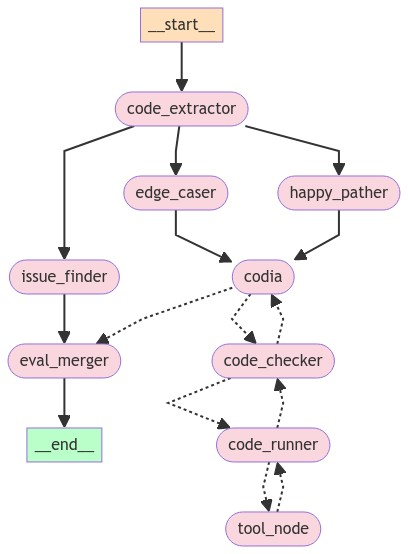

In [11]:
workflow1 = StateGraph(AgentState)
workflow1.add_node("codia", codia_node)
workflow1.add_node("issue_finder", issue_finder_node)
workflow1.add_node("code_checker", code_checker_node)
workflow1.add_node("code_runner", code_runner_node)
workflow1.add_node("eval_merger", eval_merger_node)
workflow1.add_node("code_extractor", code_extractor_node)
workflow1.add_node("happy_pather", happy_pather_node)
workflow1.add_node("edge_caser", edge_caser_node)
#workflow.add_node("testers",combine_tests_node)
workflow1.add_node("tool_node", tool_node)


nodes = [
    "happy_pather", 
    "edge_caser", 
    "issue_finder",
    ]

for node in nodes:  
    workflow1.add_edge("code_extractor", node)

nodes_to_codia = [
    "happy_pather", 
    "edge_caser", 
    ]

for node in nodes_to_codia:
    workflow1.add_edge(node, "codia")

workflow1.add_conditional_edges(
    "codia",
    router,
    {"eval_merger": "eval_merger", "code_checker": "code_checker"},
)

workflow1.add_conditional_edges(
    "code_checker",
    router,
    {"codia": "codia", "code_runner": "code_runner"},
)


workflow1.add_conditional_edges(
    "code_runner",
    router,
    { "code_checker": "code_checker", "tool_node":"tool_node"},
)

workflow1.add_edge("issue_finder", "eval_merger")



workflow1.add_conditional_edges(
    "tool_node",
    lambda x: x["sender"],
    {
        "code_runner": "code_runner",
    },
)


workflow1.add_edge(
    "eval_merger",
   END
)

workflow1.set_entry_point("code_extractor")
graph1 = workflow1.compile()


#DRAW GRAPH
from langchain_core.runnables.graph import CurveStyle, NodeColors, MermaidDrawMethod
from IPython.display import display, HTML, Image

display(
    Image(
        graph1.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)



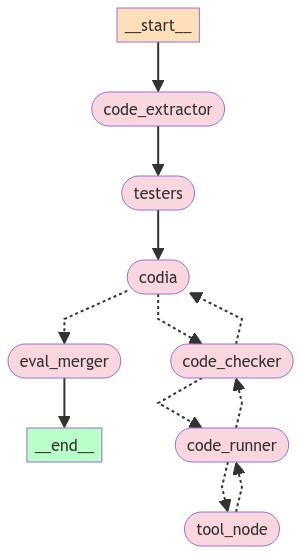

In [12]:
workflow = StateGraph(AgentState)
workflow.add_node("codia", codia_node)
# workflow.add_node("issue_finder", issue_finder_node)
workflow.add_node("code_checker", code_checker_node)
workflow.add_node("code_runner", code_runner_node)
workflow.add_node("eval_merger", eval_merger_node)
workflow.add_node("code_extractor", code_extractor_node)
# workflow.add_node("happy_pather", happy_pather_node)
# workflow.add_node("edge_caser", edge_caser_node)
workflow.add_node("testers",combine_tests_node)
workflow.add_node("tool_node", tool_node)




workflow.add_edge("code_extractor", "testers")
workflow.add_edge("testers", "codia")

workflow.add_conditional_edges(
    "codia",
    router,
    {"eval_merger": "eval_merger", "code_checker": "code_checker"},
)

workflow.add_conditional_edges(
    "code_checker",
    router,
    {"codia": "codia", "code_runner": "code_runner"},
)


workflow.add_conditional_edges(
    "code_runner",
    router,
    { "code_checker": "code_checker", "tool_node":"tool_node"},
)



workflow.add_conditional_edges(
    "tool_node",
    lambda x: x["sender"],
    {
        "code_runner": "code_runner",
    },
)


workflow.add_edge(
    "eval_merger",
   END
)

workflow.set_entry_point("code_extractor")
graph = workflow.compile()


#DRAW GRAPH
from langchain_core.runnables.graph import CurveStyle, NodeColors, MermaidDrawMethod
from IPython.display import display, HTML, Image

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)



In [13]:

notebook = load_notebook("Data/new_chirag/python_fundamentals_and_scripting__46__06_03_2024_15_46_55_1.ipynb")
messages_in = [HumanMessage(content="Here is the conversation {}".format(notebook))]

input_message = {
    "chat_history": [],
    "messages": messages_in,
    "user_config": {},
}


for s in graph.stream(input_message, {"recursion_limit": 20}):
    print("AGENT:", s)
    agent = list(s.keys())[0]
    content = s[agent]["messages"][-1].content
    if agent == "testers":
        h, e, i = json.loads(content)
        tests_content = f"Happy: {h['response']}\n\nEdge: {e['response']}\n\nIssues: {i['response']}"
        tests_content = Markdown(tests_content)
        md(tests_content)
    elif agent != "tool_node":
        #check if it is trying to call a function/tool
        if "function_call" in s[agent]["messages"][-1].additional_kwargs:
            function_being_called = s[agent]["messages"][-1].additional_kwargs['function_call']['name']
            args = s[agent]["messages"][-1].additional_kwargs['function_call']['arguments']
            content = f"I am calling the function `{function_being_called}` with the following arguments: {args}"
            content = Markdown(content)
            md(content)
        else:
            try:
                content = str(json.loads(content)["response"])
            except:
                pass
            content = Markdown(content)
            md(content)
    else:
        content = Markdown(content)
        md(content)

AGENT: {'code_extractor': {'messages': [HumanMessage(content='{"response": "```python\\nclass InsufficientPermissionsError(Exception):\\n    pass\\n\\ndef process_file(source_file_path, destination_file_path):\\n    try:\\n      # User\'s file-processing code to be integrated over here in the try-block\\n      with open(source_file_path, \'r\') as source_file:   \\n        with open(destination_file_path, \'w\') as destination_file:\\n          for line in source_file:       \\n            line = line.read()\\n            line = line.lower()\\n            destination_file.write(line)\\n      print(f\\"Successfully copied content from {source_file_path} to {destination_file_path}\\")\\n\\n    # Raise the custom exception when encountering a PermissionError\\n    except PermissionError as pe:\\n        raise InsufficientPermissionsError(f\\"Insufficient permissions to access the file: {file_path}\\") from pe\\n     \\n    except FileNotFoundError:\\n        print(f\\"The file \'{file_pat

                                                                                                                   
 class InsufficientPermissionsError(Exception):                                                                    
     pass                                                                                                          
                                                                                                                   
 def process_file(source_file_path, destination_file_path):                                                        
     try:                                                                                                          
       # User's file-processing code to be integrated over here in the try-block                                   
       with open(source_file_path, 'r') as source_file:                                                            
         with open(destination_file_path, 'w') as destination_file:                                                
           for line in source_file:                                                                                
             line = line.read()                                                                                    
             line = line.lower()                                                                                   
             destination_file.write(line)                                                                          
       print(f"Successfully copied content from {source_file_path} to {destination_file_path}")                    
                                                                                                                   
     # Raise the custom exception when encountering a PermissionError                                              
     except PermissionError as pe:                                                                                 
         raise InsufficientPermissionsError(f"Insufficient permissions to access the file: {file_path}") from pe   
                                                                                                                   
     except FileNotFoundError:                                                                                     
         print(f"The file '{file_path}' was not found.")                                                           
                                                                                                                   
     except IsADirectoryError:                                                                                     
         print(f"The path '{file_path}' is a directory, not a file.")                                              
                                                                                                                   
     # OSError could catch other I/O related errors including IOError                                              
     except OSError as e:                                                                                          
         print(f"An OS error occurred: {e}")                                                                       
                                                                                                                   
     except Exception as e:                                                                                        
         print(f"An unexpected error occurred: {e}")                                                               
                                                                                                                   
 # Example Usage                                                                                                   
                                                                                                                   
 source_file_path = "/file/to/source/source_example.txt"

AGENT: {'testers': {'messages': [HumanMessage(content='[{"response": "### Test Cases for Custom Exception Handler in File Processing Script\\n\\n#### Test Case 1: Successful File Processing\\n- **Description**: Ensure the script can successfully read from the source file and write to the destination file.\\n- **Steps**:\\n  1. Create a source file with some content.\\n  2. Define a valid destination file path.\\n  3. Call `process_file` with the source and destination paths.\\n- **Expected Outcome**: The content from the source file is copied to the destination file, and the success message is printed.\\n\\n#### Test Case 2: Source File Not Found\\n- **Description**: Handle the scenario where the source file does not exist.\\n- **Steps**:\\n  1. Define a path for a non-existent source file.\\n  2. Define a valid destination file path.\\n  3. Call `process_file` with the source and destination paths.\\n- **Expected Outcome**: The script prints \\"The file \'{file_path}\' was not found.\

Happy: ### Test Cases for Custom Exception Handler in File Processing Script                                       

                                      Test Case 1: Successful File Processing                                      

 • Description: Ensure the script can successfully read from the source file and write to the destination file.    
 • Steps:                                                                                                          
    1 Create a source file with some content.                                                                      
    2 Define a valid destination file path.                                                                        
    3 Call process_file with the source and destination paths.                                                     
 • Expected Outcome: The content from the source file is copied to the destination file, and the success message is
   printed.                                                                                                        

                                        Test Case 2: Source File Not Found                                         

 • Description: Handle the scenario where the source file does not exist.                                          
 • Steps:                                                                                                          
    1 Define a path for a non-existent source file.                                                                
    2 Define a valid destination file path.                                                                        
    3 Call process_file with the source and destination paths.                                                     
 • Expected Outcome: The script prints "The file '{file_path}' was not found."                                     

                                   Test Case 3: Destination Path is a Directory                                    

 • Description: Handle the scenario where the destination path is a directory, not a file.                         
 • Steps:                                                                                                          
    1 Create a source file with some content.                                                                      
    2 Define a destination path that points to a directory.                                                        
    3 Call process_file with the source and destination paths.                                                     
 • Expected Outcome: The script prints "The path '{file_path}' is a directory, not a file."                        

                                       Test Case 4: Insufficient Permissions                                       

 • Description: Handle the scenario where there are insufficient permissions to read the source file or write to   
   the destination file.                                                                                           
 • Steps:                                                                                                          
    1 Create a source file with some content and set its permissions to be unreadable.                             
    2 Define a valid destination file path.                                                                        
    3 Call process_file with the source and destination paths.                                                     
 • Expected Outcome: The script raises InsufficientPermissionsError with a message indicating insufficient         
   permissions.                                                                                                    

                                           Test Case 5: General OS Error                                           

 • Description: Handle an unexpected OS-related error.                                                             
 • Steps:                                     

Validating output schema.....
DEBUGG: codia :
 [HumanMessage(content='{"response": "```python\\nclass InsufficientPermissionsError(Exception):\\n    pass\\n\\ndef process_file(source_file_path, destination_file_path):\\n    try:\\n        with open(source_file_path, \'r\') as source_file:   \\n            with open(destination_file_path, \'w\') as destination_file:\\n                for line in source_file:\\n                    line = line.lower()\\n                    destination_file.write(line)\\n        print(f\\"Successfully copied content from {source_file_path} to {destination_file_path}\\")\\n\\n    except PermissionError as pe:\\n        raise InsufficientPermissionsError(f\\"Insufficient permissions to access the file: {source_file_path}\\") from pe\\n     \\n    except FileNotFoundError:\\n        print(f\\"The file \'{source_file_path}\' was not found.\\")\\n\\n    except IsADirectoryError:\\n        print(f\\"The path \'{source_file_path}\' is a directory, not a file.\\")

                                                                                                                   
 class InsufficientPermissionsError(Exception):                                                                    
     pass                                                                                                          
                                                                                                                   
 def process_file(source_file_path, destination_file_path):                                                        
     try:                                                                                                          
         with open(source_file_path, 'r') as source_file:                                                          
             with open(destination_file_path, 'w') as destination_file:                                            
                 for line in source_file:                                                                          
                     line = line.lower()                                                                           
                     destination_file.write(line)                                                                  
         print(f"Successfully copied content from {source_file_path} to {destination_file_path}")                  
                                                                                                                   
     except PermissionError as pe:                                                                                 
         raise InsufficientPermissionsError(f"Insufficient permissions to access the file: {source_file_path}") fr 
 pe                                                                                                                
                                                                                                                   
     except FileNotFoundError:                                                                                     
         print(f"The file '{source_file_path}' was not found.")                                                    
                                                                                                                   
     except IsADirectoryError:                                                                                     
         print(f"The path '{source_file_path}' is a directory, not a file.")                                       
                                                                                                                   
     except OSError as e:                                                                                          
         print(f"An OS error occurred: {e}")                                                                       
                                                                                                                   
     except Exception as e:                                                                                        
         print(f"An unexpected error occurred: {e}")                                                               
                                                                                                                   
 # Example Usage                                                                                                   
                                                                                                                   
 source_file_path = "/file/to/source/source_example.txt"                                                           
 destination_file_path = "/file/to/destination/destination_example.txt"                                            
 process_file(source_file_path=source_file_path, destination_file_path=destination_file_path)                      
                                                        

Validating output schema.....
DEBUGG: code_checker :
 [HumanMessage(content='{"response": "The provided code seems to have the following issues and potential improvements:\\n\\n1. **Logical Error in Reading Lines**:\\n    - The code reads each line using `for line in source_file:` and then attempts to call `line.read()`, which is incorrect because `line` is a string, not a file object.\\n    - **Correction**: Replace `line = line.read()` with just using `line` directly.\\n\\n2. **Undefined Variable in Exception Handling**:\\n    - The variable `file_path` is used in the exception handlers, which is not defined. It should be either `source_file_path` or `destination_file_path` based on the context.\\n    - **Correction**: Use the correct variable names in the exception messages.\\n\\n3. **Potential Misuse of `OSError`**:\\n    - The `OSError` might not be necessary if specific errors like `PermissionError`, `FileNotFoundError`, and `IsADirectoryError` are already handled.\\n\\n4. **Typo

The provided code seems to have the following issues and potential improvements:                                   

 1 Logical Error in Reading Lines:                                                                                 
    • The code reads each line using for line in source_file: and then attempts to call line.read(), which is      
      incorrect because line is a string, not a file object.                                                       
    • Correction: Replace line = line.read() with just using line directly.                                        
 2 Undefined Variable in Exception Handling:                                                                       
    • The variable file_path is used in the exception handlers, which is not defined. It should be either          
      source_file_path or destination_file_path based on the context.                                              
    • Correction: Use the correct variable names in the exception messages.                                        
 3 Potential Misuse of OSError:                                                                                    
    • The OSError might not be necessary if specific errors like PermissionError, FileNotFoundError, and           
      IsADirectoryError are already handled.                                                                       
 4 Typographical Errors:                                                                                           
    • There are typos in the example usage paths: destionation should be destination.                              
 5 Improper Use of .lower():                                                                                       
    • The .lower() method should be applied directly to line without reading it again.                             
 6 Inefficient File Processing:                                                                                    
    • The file processing can be more efficient by reading and writing chunks instead of line by line.             

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                                                 Corrected Code                                                  ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛

                                                                                                                   
 class InsufficientPermissionsError(Exception):                                                                    
     pass                                                                                                          
                                                                                                                   
 def process_file(source_file_path, destination_file_path):                                                        
     try:                                                                                                          
         with open(source_file_path, 'r') as source_file:                                                          
             with open(destination_file_path, 'w') as destination_file:                                            
                 for line in source_file:                                                                          
                     line = line.lower()                                                                           
                     destination_file.write(line)                                                                  
         print(f"Successfully copied content from {source_file_path} to {destination_file_path}")                  
                                                                                                                   
     except PermissionError as pe:                   

TYPE: content='' additional_kwargs={'function_call': {'arguments': '\n    \r\n\r\n\r\n    \r\n   \r\n\r\n   \r\n   \r\n   \r\n\r\n   \r\n  \r\n\r\n    \r\n   \r\n  \r\n\r\n  \r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n\r\n  \r\n

AttributeError: 'list' object has no attribute 'additional_kwargs'

In [ ]:
parser = PydanticOutputParser(pydantic_object=StandardResponse)
standard_format = parser.get_format_instructions()
print(standard_format)

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"description": "Represents a standard response from the agent/ai.", "properties": {"response": {"description": "your actual response/answer in markdown format", "title": "Response", "type": "string"}, "sender": {"description": "your name in lowercase", "title": "Sender", "type": "string"}, "directed_to": {"description": "your response must be directed to another agent or to human", "title": "Directed To", "type": "string"}}, "required": ["response", "sender", "directed_to"]}
```
